# NLP classification - supervised learning

In this example, you will learn how you can use supervised learning algorithms for NLP classification. We will use documents from https://www.reddit.com/r/domesticviolence/ and https://www.reddit.com/r/emotionalabuse/ The task is to classify a document into two different types of violence: violence or not.

We will use classification algorithms as implemented in sci-kit learn, and evaluate with cross-validation before testing on unseen test data.

We will experiment with different ways of representing the documents for the classifiers.

material in parts from https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

Written by Sumithra Velupillai, March 2019 - updated February 2020

# 1: Import packages

In [37]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
try:
    import xlrd
except ImportError as e:
    !pip install xlrd
    import xlrd

import numpy as np

import warnings; warnings.simplefilter('ignore')

In [38]:
# We'll use scikit-learn for the classification algorithms.
# https://scikit-learn.org/stable/

#from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [39]:
## sklearn also has some nice funtions for representations

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

## and for evaluation
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

In [40]:
## Since we're working with text, we might need to tokenize for some of these representations. 
# We'll use nltk here, but there are other nlp packages available for this
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /Users/lilifang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lilifang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [41]:
# You have also learnt about embedding representations. These can also be used for classification.
# We will use a library called Zeugma, which allows using pre-trained embedding models
#Zeugma library: https://github.com/nkthiebaut/zeugma

try:
    from zeugma.embeddings import EmbeddingTransformer
except ImportError as e:
    !pip install zeugma
    !pip install theano
    from zeugma.embeddings import EmbeddingTransformer

from datetime import datetime
print(datetime.now())

2022-04-23 16:04:19.193473


# 2: Corpus 
Reading in the training data

In [42]:
#Read the whole dataset
data= pd.read_csv('violence_data_900_sample.csv')
print(data.shape)
print(data.columns)
print(data.describe())
data=data[['label','selftext']]
print(data.shape)

(900, 3)
Index(['index', 'label', 'selftext'], dtype='object')
            index       label
count  900.000000  900.000000
mean   500.001111    0.521111
std    288.481107    0.499832
min      1.000000    0.000000
25%    251.750000    0.000000
50%    497.500000    1.000000
75%    751.250000    1.000000
max    999.000000    1.000000
(900, 2)


In [43]:
# split data into training and test data
'''
We may use train_test_split method in sklearn
'''
from sklearn.model_selection import train_test_split
X=data['selftext']
y=data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [74]:
trainingdata= pd.concat([X_train, pd.DataFrame(y_train)], axis=1)
print(trainingdata.shape)

print(trainingdata.columns)
print(trainingdata['label'].value_counts()) 

(720, 2)
Index(['selftext', 'label'], dtype='object')
1    374
0    346
Name: label, dtype: int64


In [75]:
# If we have done some mannual labeled data, we will combine those labeled data and use them as the test data

# 1, re-read training data
trainingdata= data
print(trainingdata.shape)
# 2, generate test data from different coders' labeled data
coderA= pd.DataFrame()
# change the number
for i in range(1,2):
    df = pd.read_csv('Sample_data'+str(i)+'_to_label_A.csv')
    coderA=coderA.append(df)
print(coderA.shape)
print(coderA.head())

coderB= pd.DataFrame()
for i in range(1,2):
    df = pd.read_csv('Sample_data'+str(i)+'_to_label_B.csv')
    coderB=coderB.append(df)
print(coderB.shape)
print(coderB.head())

(900, 2)
(20, 3)
   label                                           selftext  index
0      1  yesterday some guy threatened us to sell our h...    177
1      1   On one hand he is a very kind and considerate...    153
2      1   I have never been violent or manipulative dur...    514
3      0   Honestly I'm hurt so much by him I do in fact...    297
4      0  I can__ do this anymore basically it__ your ty...    108
(20, 3)
   label                                           selftext  index
0      1  yesterday some guy threatened us to sell our h...    177
1      1   On one hand he is a very kind and considerate...    153
2      1   I have never been violent or manipulative dur...    514
3      0   Honestly I'm hurt so much by him I do in fact...    297
4      0  I can__ do this anymore basically it__ your ty...    108


Inter-Annotator Agreement (IAA), a measure of how well multiple annotators can make the same annotation decision for a certain category. Supervised Natural Language Processing algorithms use a labeled dataset, that is often annotated by humans. Here, it would be the annotation scheme for this workshop, where posts were labeled as either violence or non-violence (based on selftext).

Pair-wise Cohen kappa and group Fleiss’ kappa (𝜅) coefficients can be applied, we will use Cohen kappa here.
For other details, please refer to this link: https://towardsdatascience.com/inter-annotator-agreement-2f46c6d37bf3

In [76]:
# calculate coderA and coderB's IAA, in this edition, I just tried the first sample data by myself
from sklearn.metrics import cohen_kappa_score
labelerA = coderA['label']
labelerB = coderB['label']
IAA_AB=cohen_kappa_score(labelerA, labelerB)
print(IAA_AB)

0.4666666666666667


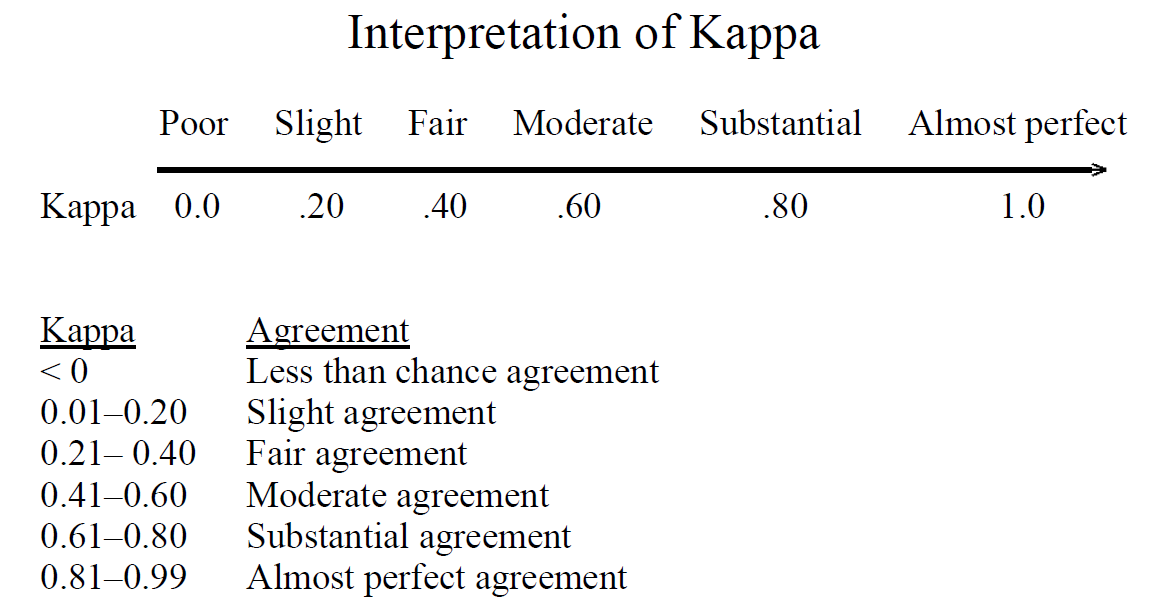

In [80]:
from IPython.display import Image
Image(filename='kappa.png')


Viera, A. J., & Garrett, J. M. (2005). 
Understanding interobserver agreement: the kappa statistic. 
Fam med, 37(5), 360-363. 

cited:7812

# 3: Representation - BoW
The most common baseline feature representation for text classification tasks is to use the bag-of-words representation, in a document-term matrix. Let's build a simple one using raw counts and only keeping a maximum of 500 features. We can use the CountVectorizer function from sklearn, and tokenize using a function from nltk.

In [96]:
first_vectorizer = CountVectorizer(ngram_range=(1,1), stop_words=None,
                             tokenizer=word_tokenize, max_features=500)
first_vectorizer.fit(trainingdata['selftext'].tolist())
first_fit_transformed_data = first_vectorizer.fit_transform(trainingdata['selftext'])

In [97]:
# What word is represented by the different indices? Have a look at a few examples.
print (first_vectorizer.get_feature_names()[32])
print(first_fit_transformed_data.shape)
print ('Amount of Non-Zero occurences: ', first_fit_transformed_data.nnz)

``
(900, 500)
Amount of Non-Zero occurences:  11712


# 4: Classification
Let's build a classifier with this feature representation. In text classification, many classification algorithms have been shown to work well. Sci-kit learn has implementations for many different types of classification algorithms - have a look at their website!

Let's try a K nearest neighbour classifier.

In [98]:

#kneighbour_classifier = KNeighborsClassifier().fit(first_fit_transformed_data, trainingdata['role'])

We now have a trained model. But how do we know how well it works? Let's evaluate it on the test data.

In [99]:
testdata= pd.concat([X_test, pd.DataFrame(y_test)], axis=1)
print(testdata.shape)
testdata['label'].value_counts()

(180, 2)


1    95
0    85
Name: label, dtype: int64

In [100]:
# If we try to use the labeled data as follows:
print(coderA.columns)
print(coderB.columns)
new_df = pd.merge(coderA,coderB,on='index')
print(new_df.columns) # ['label_x', 'selftext_x', 'index', 'label_y', 'selftext_y']
print(coderA.shape,coderB.shape,new_df.shape)
same_df = new_df[new_df['label_x']==new_df['label_y']]
print(same_df.shape)

diff_df = pd.concat([new_df,same_df]).drop_duplicates(keep=False)
print(diff_df['index'])
print(diff_df.shape)
print(diff_df)

Index(['label', 'selftext', 'index'], dtype='object')
Index(['label', 'selftext', 'index'], dtype='object')
Index(['label_x', 'selftext_x', 'index', 'label_y', 'selftext_y'], dtype='object')
(20, 3) (20, 3) (20, 5)
(16, 5)
7     815
10    359
13     32
18    319
Name: index, dtype: int64
(4, 5)
    label_x                                         selftext_x  index  \
7         1  Why do I still love my ex who passed away mont...    815   
10        0   He leaves for several days at a time only to ...    359   
13        1  So she's with him for like 4 years now and I h...     32   
18        0   I (26y/F) am currently 26 weeks pregnant &amp...    319   

    label_y                                         selftext_y  
7         0  Why do I still love my ex who passed away mont...  
10        1   He leaves for several days at a time only to ...  
13        0  So she's with him for like 4 years now and I h...  
18        1   I (26y/F) am currently 26 weeks pregnant &amp...  


In [101]:
# we need to re-label the rest data if the cohen's Kappa value is not reasonable. 
# Here we just assmue that, we agree with coder B's results, then:
testdata = new_df[['index', 'label_y', 'selftext_y']]
testdata = testdata.rename(columns={"label_y": "label", 'selftext_y':'selftext'})
print(testdata.columns)

Index(['index', 'label', 'selftext'], dtype='object')


In [102]:
## We need to transform this data to the same representation
first_fit_transformed_testdata = first_vectorizer.transform(testdata['selftext'])
kneighbour_classifier = KNeighborsClassifier().fit(first_fit_transformed_data, trainingdata['label'])
print(first_fit_transformed_testdata)
kneighbour_predicted = kneighbour_classifier.predict(first_fit_transformed_testdata)
print(kneighbour_predicted)
print("Accuracy:",metrics.accuracy_score(testdata['label'],kneighbour_predicted ))
#print(metrics.classification_report(testdata['label'], kneighbour_predicted, target_names=set(testdata['label'].tolist())))
#print(metrics.classification_report(testdata['label'], kneighbour_predicted, target_names=set(testdata['label'].tolist())))

  (0, 4)	1
  (0, 8)	1
  (0, 33)	1
  (0, 45)	1
  (0, 58)	4
  (0, 69)	1
  (0, 76)	1
  (0, 160)	1
  (0, 182)	1
  (0, 197)	2
  (0, 207)	4
  (0, 218)	2
  (0, 224)	1
  (0, 296)	1
  (0, 302)	1
  (0, 317)	2
  (0, 330)	1
  (0, 367)	1
  (0, 381)	1
  (0, 390)	1
  (0, 416)	3
  (0, 417)	1
  (0, 431)	1
  (0, 436)	1
  (0, 455)	1
  :	:
  (18, 48)	1
  (18, 55)	2
  (18, 56)	1
  (18, 122)	1
  (18, 126)	1
  (18, 127)	1
  (18, 139)	1
  (18, 164)	1
  (18, 170)	1
  (18, 180)	2
  (18, 230)	2
  (18, 263)	1
  (18, 350)	1
  (18, 395)	1
  (18, 417)	2
  (18, 436)	1
  (18, 454)	1
  (18, 469)	1
  (18, 471)	1
  (19, 164)	1
  (19, 239)	1
  (19, 302)	1
  (19, 417)	1
  (19, 420)	1
  (19, 451)	1
[0 1 1 0 1 0 1 1 0 0 0 1 1 1 1 1 1 1 0 0]
Accuracy: 0.55


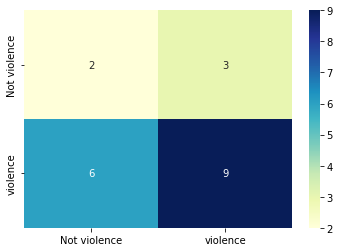

In [103]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
x_axis_labels = ['Not violence','violence'] # labels for x-axis
y_axis_labels = ['Not violence','violence'] # labels for y-axis

cm =confusion_matrix(testdata['label'], kneighbour_predicted)
cm_plot = sns.heatmap(cm, cmap="YlGnBu",annot=True, fmt="d",xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.show()

We need to use some other classifiers to check which one is better:RandomForestClassifier

In [104]:
from sklearn.ensemble import RandomForestClassifier
RandomForestClassifier = RandomForestClassifier().fit(first_fit_transformed_data, trainingdata['label'])

first_fit_transformed_testdata = first_vectorizer.transform(testdata['selftext'])
print(first_fit_transformed_testdata)
RandomForestClassifier_predicted = RandomForestClassifier.predict(first_fit_transformed_testdata)
print(RandomForestClassifier_predicted)
#print(metrics.classification_report(testdata['label'], RandomForestClassifier_predicted, target_names=set(testdata['label'].tolist())))
print("Accuracy:",metrics.accuracy_score(testdata['label'], RandomForestClassifier_predicted))

  (0, 4)	1
  (0, 8)	1
  (0, 33)	1
  (0, 45)	1
  (0, 58)	4
  (0, 69)	1
  (0, 76)	1
  (0, 160)	1
  (0, 182)	1
  (0, 197)	2
  (0, 207)	4
  (0, 218)	2
  (0, 224)	1
  (0, 296)	1
  (0, 302)	1
  (0, 317)	2
  (0, 330)	1
  (0, 367)	1
  (0, 381)	1
  (0, 390)	1
  (0, 416)	3
  (0, 417)	1
  (0, 431)	1
  (0, 436)	1
  (0, 455)	1
  :	:
  (18, 48)	1
  (18, 55)	2
  (18, 56)	1
  (18, 122)	1
  (18, 126)	1
  (18, 127)	1
  (18, 139)	1
  (18, 164)	1
  (18, 170)	1
  (18, 180)	2
  (18, 230)	2
  (18, 263)	1
  (18, 350)	1
  (18, 395)	1
  (18, 417)	2
  (18, 436)	1
  (18, 454)	1
  (18, 469)	1
  (18, 471)	1
  (19, 164)	1
  (19, 239)	1
  (19, 302)	1
  (19, 417)	1
  (19, 420)	1
  (19, 451)	1
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Accuracy: 0.75


You can also try other classifiers by yourself.

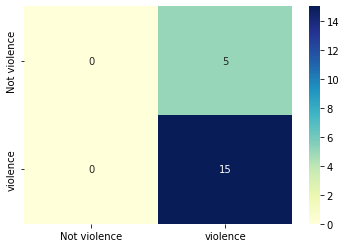

In [105]:
import seaborn as sns
x_axis_labels = ['Not violence','violence'] # labels for x-axis
y_axis_labels = ['Not violence','violence'] # labels for y-axis

cm =confusion_matrix(testdata['label'], RandomForestClassifier_predicted)
cm_plot = sns.heatmap(cm, cmap="YlGnBu",annot=True, fmt="d",xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.show()

In [106]:
## We need to transform this data to the same representation
from sklearn.tree import DecisionTreeClassifier
DecisionTreeClassifier = DecisionTreeClassifier().fit(first_fit_transformed_data, trainingdata['label'])
first_fit_transformed_testdata = first_vectorizer.transform(testdata['selftext'])
print(first_fit_transformed_testdata)
DecisionTree_predicted = DecisionTreeClassifier.predict(first_fit_transformed_testdata)
print(DecisionTree_predicted)
print("Accuracy:",metrics.accuracy_score(testdata['label'], DecisionTree_predicted))

  (0, 4)	1
  (0, 8)	1
  (0, 33)	1
  (0, 45)	1
  (0, 58)	4
  (0, 69)	1
  (0, 76)	1
  (0, 160)	1
  (0, 182)	1
  (0, 197)	2
  (0, 207)	4
  (0, 218)	2
  (0, 224)	1
  (0, 296)	1
  (0, 302)	1
  (0, 317)	2
  (0, 330)	1
  (0, 367)	1
  (0, 381)	1
  (0, 390)	1
  (0, 416)	3
  (0, 417)	1
  (0, 431)	1
  (0, 436)	1
  (0, 455)	1
  :	:
  (18, 48)	1
  (18, 55)	2
  (18, 56)	1
  (18, 122)	1
  (18, 126)	1
  (18, 127)	1
  (18, 139)	1
  (18, 164)	1
  (18, 170)	1
  (18, 180)	2
  (18, 230)	2
  (18, 263)	1
  (18, 350)	1
  (18, 395)	1
  (18, 417)	2
  (18, 436)	1
  (18, 454)	1
  (18, 469)	1
  (18, 471)	1
  (19, 164)	1
  (19, 239)	1
  (19, 302)	1
  (19, 417)	1
  (19, 420)	1
  (19, 451)	1
[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Accuracy: 0.7


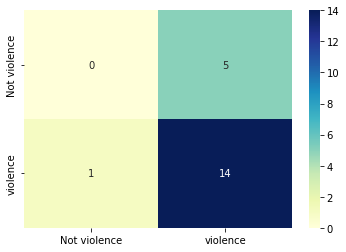

In [107]:
import seaborn as sns
x_axis_labels = ['Not violence','violence'] # labels for x-axis
y_axis_labels = ['Not violence','violence'] # labels for y-axis

cm =confusion_matrix(testdata['label'], DecisionTree_predicted)
cm_plot = sns.heatmap(cm, cmap="YlGnBu",annot=True, fmt="d",xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.show()

# 5: N-fold cross-validation
We can employ n-fold cross-validation on the training data to experiment with different representations, parameters, and classifiers.
There are also various metrics that can be used to evaluate classification results.

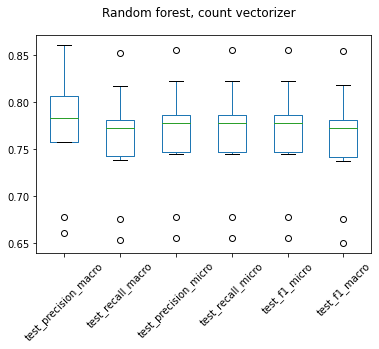

In [108]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0).fit(first_fit_transformed_data, trainingdata['label'])
scoring = ['precision_macro', 'recall_macro','precision_micro','recall_micro', 'f1_micro', 'f1_macro']
scores = cross_validate(rf_classifier, first_fit_transformed_data, trainingdata['label'], scoring=scoring, cv=10, return_train_score=False)
scoresdf = pd.DataFrame(scores)
scoring = ['test_precision_macro', 'test_recall_macro','test_precision_micro','test_recall_micro', 'test_f1_micro', 'test_f1_macro']
bp = scoresdf.boxplot(column=scoring, grid=False, rot=45,)
[ax_tmp.set_xlabel('') for ax_tmp in np.asarray(bp).reshape(-1)]
fig = np.asarray(bp).reshape(-1)[0].get_figure()
fig.suptitle('Random forest, count vectorizer')
plt.show()

# 6: Another representation model: Tf-idf¶
We have used a very simple bag-of-words representation.
 What happens if we try something else? Let's try tf-idf. 
 This is considered a strong baseline in many text classification tasks.

In [109]:
stopWords = set(stopwords.words('english'))
tfidf_vect = TfidfVectorizer(tokenizer=word_tokenize, stop_words=stopWords)
tfidf_vect.fit(trainingdata['selftext'])
second_fit_transformed_data =  tfidf_vect.transform(trainingdata['selftext'])
second_fit_transformed_data

<900x2217 sparse matrix of type '<class 'numpy.float64'>'
	with 7872 stored elements in Compressed Sparse Row format>

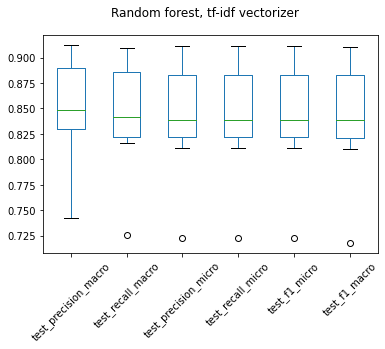

In [110]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier2 = RandomForestClassifier().fit(second_fit_transformed_data, trainingdata['label'])
scoring = ['precision_macro', 'recall_macro','precision_micro','recall_micro', 'f1_micro', 'f1_macro']
scores = cross_validate(rf_classifier2, second_fit_transformed_data, trainingdata['label'], scoring=scoring, cv=10, return_train_score=False)
scoresdf = pd.DataFrame(scores)
scoring = ['test_precision_macro', 'test_recall_macro','test_precision_micro','test_recall_micro', 'test_f1_micro', 'test_f1_macro']
bp = scoresdf.boxplot(column=scoring, grid=False, rot=45,)
[ax_tmp.set_xlabel('') for ax_tmp in np.asarray(bp).reshape(-1)]
fig = np.asarray(bp).reshape(-1)[0].get_figure()
fig.suptitle('Random forest, tf-idf vectorizer')
plt.show()

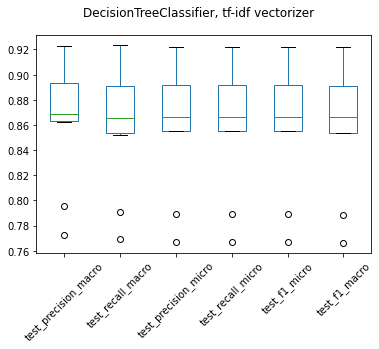

In [111]:
from sklearn.tree import DecisionTreeClassifier
DecisionTreeClassifier2 = DecisionTreeClassifier().fit(second_fit_transformed_data, trainingdata['label'])
scoring = ['precision_macro', 'recall_macro','precision_micro','recall_micro', 'f1_micro', 'f1_macro']
scores = cross_validate(DecisionTreeClassifier2, second_fit_transformed_data, trainingdata['label'], scoring=scoring, cv=10, return_train_score=False)
scoresdf = pd.DataFrame(scores)
scoring = ['test_precision_macro', 'test_recall_macro','test_precision_micro','test_recall_micro', 'test_f1_micro', 'test_f1_macro']
bp = scoresdf.boxplot(column=scoring, grid=False, rot=45,)
[ax_tmp.set_xlabel('') for ax_tmp in np.asarray(bp).reshape(-1)]
fig = np.asarray(bp).reshape(-1)[0].get_figure()
fig.suptitle('DecisionTreeClassifier, tf-idf vectorizer')
plt.show()
# We can see that the DecisionTreeClassifier performs pretty good in this case

From the above figures, we can see that the performance of the applied classifiers:
 Random Forest classifier with TF-IDF > Random Forest> KNN

# 7: Representations: embeddings
For the embedding representations.

We will try Zeugma which is a package where you can use embeddings in sklearn. https://github.com/nkthiebaut/zeugma

It allows you to directly download pre-trained models that have been released from the gensim website.

Let's use a basic glove model. 
 
We will check what might be the benefit of using this type of representation instead of counts or tf-idf?

In [112]:
glove = EmbeddingTransformer('glove')
glove_transformed_training_data = glove.transform(trainingdata['selftext'])
print(glove_transformed_training_data)

[[-0.28462732  0.4530867  -0.096233   ... -0.44266167 -0.5407338
  -0.6172367 ]
 [ 0.02876019  0.49749777 -0.0247744  ... -0.21045253 -0.09218549
  -0.48816082]
 [ 0.12404031  0.1960328   0.13787733 ... -0.05698626 -0.10491054
  -0.20984922]
 ...
 [-0.1602648   0.3461491   0.44487864 ...  0.4112358  -0.0180772
  -0.25251347]
 [-0.6160287   0.22391248  0.7457125  ...  0.98865867 -0.15616125
  -0.15990874]
 [-0.2695033   0.26947048  0.3326285  ...  0.05461852 -0.10841548
  -0.29715607]]


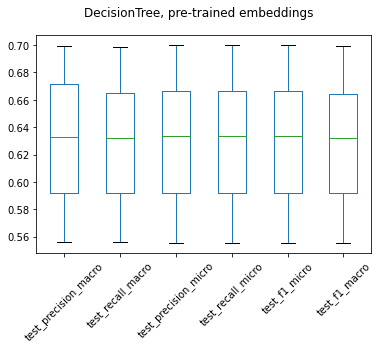

In [113]:
from sklearn.tree import DecisionTreeClassifier
DecisionTreeClassifier = DecisionTreeClassifier().fit(glove_transformed_training_data, trainingdata['label'])
scoring = ['precision_macro', 'recall_macro','precision_micro','recall_micro', 'f1_micro', 'f1_macro']
scores = cross_validate(DecisionTreeClassifier, glove_transformed_training_data, trainingdata['label'], scoring=scoring, cv=10, return_train_score=False)
scoresdf = pd.DataFrame(scores)
scoring = ['test_precision_macro', 'test_recall_macro','test_precision_micro','test_recall_micro', 'test_f1_micro', 'test_f1_macro']
bp = scoresdf.boxplot(column=scoring, grid=False, rot=45,)
[ax_tmp.set_xlabel('') for ax_tmp in np.asarray(bp).reshape(-1)]
fig = np.asarray(bp).reshape(-1)[0].get_figure()
fig.suptitle('DecisionTree, pre-trained embeddings')
plt.show()

# 8: Classifiers, representations, evaluation
You've now seen that you get very different results depending on which representation you use, which classifier, and also that there are many different metrics to analyse.

Let's try some different configurations all in one go. We'll create a dictionary with the three different types of representations, and a list of different classification algorithms, and apply all these configurations to see what seems to yield best results according to a chosen evaluation metric using 10-fold cross validation.

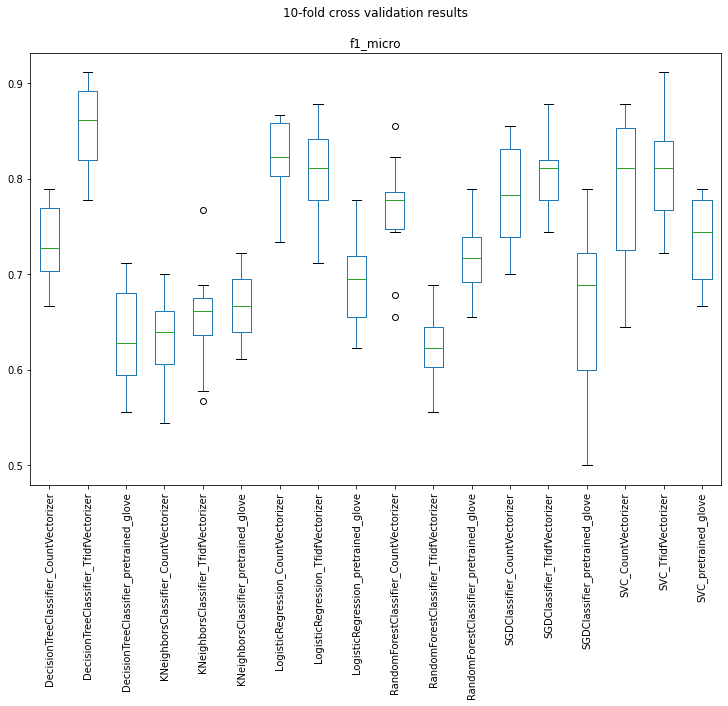

In [114]:
from sklearn.tree import DecisionTreeClassifier
representations = {}

vectorizer = CountVectorizer(ngram_range=(1,1), stop_words=None,
                             tokenizer=word_tokenize, max_features=500)
xtrain_countvect = vectorizer.fit_transform(trainingdata['selftext'])
representations['CountVectorizer'] = xtrain_countvect

tfidf_vect = TfidfVectorizer(tokenizer=word_tokenize, stop_words=stopWords)
tfidf_vect.fit(trainingdata['selftext'])
xtrain_tfidf =  tfidf_vect.transform(trainingdata['selftext'])
representations['TfidfVectorizer'] = xtrain_tfidf

x_train_glove = glove.transform(trainingdata['selftext'])
representations['pretrained_glove'] = x_train_glove



CV = 10

classifier_models = [
        RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
        DecisionTreeClassifier(),
        SVC(),
     #    LinearSVC(multi_class='ovr', C=1.0, class_weight=None, dual=True, fit_intercept=True,
     # intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     #  penalty='l2', random_state=0, tol=1e-05, verbose=0),
        SGDClassifier(),
        LogisticRegression(random_state=0),
        KNeighborsClassifier(),
]

cv_df = pd.DataFrame(index=range(CV * (len(classifier_models)*len(representations))))
entries = []

for representation, transformed_vector in representations.items():
    score = 'f1_micro'
    for model in classifier_models:
      model_name = model.__class__.__name__+'_'+representation
      accuracies = cross_val_score(model, transformed_vector, trainingdata['label'], scoring=score, cv=CV)
      #accuracies = cross_val_score(model, transformed_vector, trainingdata['role'], scoring=score, cv=CV)
      for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', score])
bp = cv_df.boxplot(by='model_name', column=[score], grid=False, rot=90, figsize=(12,8))
[ax_tmp.set_xlabel('') for ax_tmp in np.asarray(bp).reshape(-1)]
fig = np.asarray(bp).reshape(-1)[0].get_figure()
fig.suptitle('10-fold cross validation results')
plt.show()